<a href="https://colab.research.google.com/github/Damisss/End-to-end-Gun-Detection-in-TFLite-and-opencv/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab.patches import cv2_imshow
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
print(tf.__version__)


2.3.0


#Let's download our dataset

In [ ]:
# first will download the our full dataset
%%bash
gdown --id 1KeusEvIgU9SeQuqSU7pTTye-wpYFtvnC

Downloading...
From: https://drive.google.com/uc?id=1KeusEvIgU9SeQuqSU7pTTye-wpYFtvnC
To: /content/dataset.zip
252MB [00:02, 121MB/s]


In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/test/armas_1819.xml  
  inflating: dataset/test/armas_1170.jpg  
  inflating: dataset/test/armas_894.xml  
  inflating: dataset/test/armas_1428.xml  
  inflating: dataset/test/armas_102.xml  
  inflating: dataset/test/armas_843.jpg  
  inflating: dataset/test/armas_670.xml  
  inflating: dataset/test/armas_2135.xml  
  inflating: dataset/test/armas_102.jpg  
  inflating: dataset/test/armas_843.xml  
  inflating: dataset/test/armas_1428.jpg  
  inflating: dataset/test/armas_670.jpg  
  inflating: dataset/test/armas_2135.jpg  
  inflating: dataset/test/armas_894.jpg  
  inflating: dataset/test/armas_1560.xml  
  inflating: dataset/test/armas_2082.jpg  
  inflating: dataset/test/armas_1212.xml  
  inflating: dataset/test/armas_2914.jpg  
  inflating: dataset/test/armas_2733.xml  
  inflating: dataset/test/armas_704.xml  
  inflating: dataset/test/armas_71.xml  
  inflating: dataset/test/armas_2733.jpg  
  inflating: d

In [ ]:
# upload and unzip our inference graph that we have generated in training notebook
!unzip inference_graph.zip

Archive:  inference_graph.zip
   creating: inference_graph/
  inflating: inference_graph/checkpoint  
  inflating: inference_graph/model.ckpt.meta  
  inflating: inference_graph/frozen_inference_graph.pb  
  inflating: inference_graph/pipeline.config  
  inflating: inference_graph/model.ckpt.index  
  inflating: inference_graph/tflite_graph.pb  
  inflating: inference_graph/model.ckpt.data-00000-of-00001  
  inflating: inference_graph/tflite_graph.pbtxt  
   creating: inference_graph/saved_model/
   creating: inference_graph/saved_model/variables/
  inflating: inference_graph/saved_model/saved_model.pb  


Dynamic-range conversion

In [ ]:
#convert pb graph to tflite one
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='inference_graph/tflite_graph.pb',
    input_arrays=['normalized_input_image_tensor'],              
    output_arrays=['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'],
    input_shapes={'normalized_input_image_tensor': [1, 300, 300, 3]}
)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open('weapons_detector.tflite', 'wb') as f:
  f.write(tflite_quant_model)

# Inference

In [ ]:
LABELS = ['Pistol']

In [ ]:
def preprocess_image(frame, width, height):
    #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #img = Image.fromarray(img)
    img = cv2.resize(img, (width, height))
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
class Inference ():
  @staticmethod
  def start (imagePath):
    try:
      interpreter = tf.lite.Interpreter(model_path="weapons_detector.tflite")
      interpreter.allocate_tensors()
      input_details = interpreter.get_input_details()
      ouput_details = interpreter.get_output_details()
      width = input_details[0]['shape'][1]
      height = input_details[0]['shape'][2]
      frame = cv2.imread(imagePath)
      #Preprocess input image
      preprocessedImg = preprocess_image(frame, height, width)
      preprocessedImg = preprocessedImg.astype('float32')
      input_mean = 127.5
      input_std = 127.5
      H, W = frame.shape[:2]
      #
      preprocessedImg = (preprocessedImg - input_mean) / input_std
      start_time = time.monotonic()
      interpreter.set_tensor(input_details[0]['index'], preprocessedImg)
      interpreter.invoke()
      bboxes = interpreter.get_tensor(ouput_details[0]['index'])[0] #bounding box
      classIds = interpreter.get_tensor(ouput_details[1]['index'])[0] # classIds
      scores = interpreter.get_tensor(ouput_details[2]['index'])[0] # scores
      
      print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

      for i in range(len(scores)):
        score = scores[i]

        if score >= .5:
          xmin = int(bboxes[i][1] * W)
          ymin = int(bboxes[i][0] * H)
          xmax = int(bboxes[i][3] * W)
          ymax = int(bboxes[i][2] * H)

          cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), 
                    (255, 0, 0), 2)
          y = ymin - 15 if ymin - 15 > 15 else ymin + 15
          ind = int(classIds[i])
          label = '{} {:.2f}%'.format(LABELS[ind], score*100)
          font = cv2.FONT_HERSHEY_SIMPLEX
          cv2.putText(frame, label, (xmin, y), font, .5, (255, 0, 0), 2)
          
      cv2_imshow(frame)

    except Exception as e:
      raise e

Elapsed time: 328.55992000077094 miliseconds


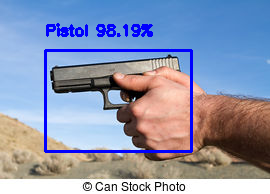

In [ ]:
Inference.start('dataset/test/armas_313.jpg')